### 

<div style="text-align:center;">
    <h2>cda2/4Da Policy Advices zur Energieerzeugung ohne Treibhausgasausstoss</h2>
    <p>Marius Läubli, Weiping Zhang</p>
    <p>Data Science Bachelor Program, FHNW</p>
    <p>JUNE 2023</p>
</div>


- This notebook includes how we connect (data source), modify, aggregate all final data which are used in our dashboard and story telling report.
- All the data are queried by API, as long as the connections still work, we could simply run over the whole notebook to get the 
data and our interactive dashboard updated in a few minutens.
- Data source: rte-France, smard, terna, uvek-gis

In [33]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import requests
import json
from openpyxl import load_workbook
import xml.etree.ElementTree as ET
from requests.auth import HTTPBasicAuth
from datetime import datetime, timedelta
from openpyxl.utils import get_column_letter, column_index_from_string
import time

## 1 Life-cycle greenhouse gas emissions of energy sources

- We use the life cycle CO2 emissions per kWh mainly from IPCC 2014, rte, UNECE 2020 and the supervisor's private connection.
### 1.1 Source
#### 1.1.1 rte-France
- The contribution of each energy source to C02 emissions is as follows:

    - 0.986 t CO2 eq /MWh for coal-fired plants
    - 0.777 t CO2 eq /MWh for oil-fired plants
    - 0.429 t CO2 eq /MWh for gas-fired plants
    - 0.494 t CO2 eq /MWh for biofuel plants (waste)
    - 0.486 t CO2 eq /MWh for gas-turbine plants
    - 0.352 t CO2 eq /MWh for co-generation & combined-cycle plants
    - 0.583 t CO2 eq /MWh for other gas-fired plants
    - 0.494 t CO2 eq /MWh for household waste
    - For energy sources that are not mentioned, their contribution to CO2 emissions is considered equal to 0 t CO2 eq / MWh. 
- https://www.rte-france.com/en/eco2mix/co2-emissions
    
#### 1.1.2 Lifecycle CO2 emissions per kWh from IPCC 2014 & UNECE 2020 (EU28 countries):
- List of acronyms:
    - PC — pulverized coal
    - CCS — carbon capture and storage
    - IGCC — integrated gasification combined cycle
    - SC — supercritical
    - NGCC — natural gas combined cycle
    - CSP — concentrated solar power
    - PV — photovoltaic power
- https://en.wikipedia.org/wiki/Life-cycle_greenhouse_gas_emissions_of_energy_sources#cite_note-:0-5

#### 1.1.3 from private connection
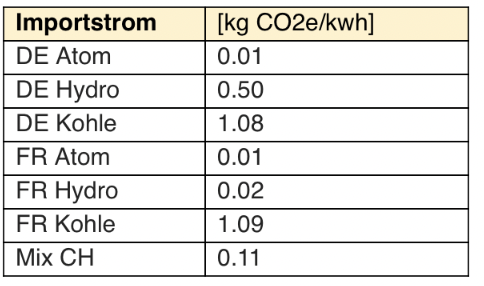

### 1.2 generate co2 intensity table

In [34]:
# CO2 intensity; 
# unit: gCO2eq/kWh
co2_intensity = pd.DataFrame()
co2_intensity['technology'] = ['coal','natural gas','other renewables','oil','biomass','solarPV rooftop',
                          'solarPV utilityscale','solarPV rooftop&utilityscale','solarPV concentrated',
                          'solarPV polySi ground-mounted', 'solarPV polySi roof-mounted',
                          'geothermal','hydro','wind offshore','wind onshore','nuclear',
                          'waste','ocean','other conventional','de nuclear','de hydro','de coal', 'fr nuclear', 'fr hydro', 'fr coal']
co2_intensity['median'] = [820,490,400,777,230,41,48,44.5,27,37,37,38,24,12,12,12,494,17,645, 10, 500, 1080, 10, 20, 1090]
co2_intensity

,technology,median
0,coal,820.0
1,natural gas,490.0
2,other renewables,400.0
3,oil,777.0
4,biomass,230.0
5,solarPV rooftop,41.0
6,solarPV utilityscale,48.0
7,solarPV rooftop&utilityscale,44.5
8,solarPV concentrated,27.0
9,solarPV polySi ground-mounted,37.0


## 2 actual electricity generation
### 2.1 France: electricity actual generation data from rte
- available earliest from 2015-01-01, can one time maximum 4 month data query
- data is updated every hour

#### 2.1.1 query data 

In [3]:
# This is the URL to get  the token
oauthurl = "https://digital.iservices.rte-france.com/token/oauth"
# This is the URL to get the data
url = "https://digital.iservices.rte-france.com/open_api/actual_generation/v1/sandbox/actual_generations_per_production_type"

# These are the credentials to get the token
client_id = "9193848f-833f-4a25-aea9-84ad6cacddd4"
client_secret = "4eec2909-64e8-43be-be11-493131b580ce"
# This is the payload to get the token
auth = HTTPBasicAuth(client_id, client_secret)
response = requests.get(oauthurl, auth=auth)
# Check response status code
if response.status_code == 200:
    # If the response is OK, get the token from the response
    data = response.json()
    token = data['access_token']
else:
    print("Error:", response.status_code, response.reason)   
headers = {
    "Authorization": "Bearer " + token}
# Make the request
response = requests.get(url, headers=headers)
# Check response status code
if response.status_code == 200:
    # If the response is OK, get the data from the response
    data = response.json()
else:
    print("Error:", response.status_code, response.reason)

In [4]:
url = "https://digital.iservices.rte-france.com/open_api/actual_generation/v1/actual_generations_per_production_type"
def generate_date_list(start_year, start_month):
    start_date = datetime(year=start_year, month=start_month, day=1)
    end_date = datetime.now()
    date_list = []
    while start_date <= end_date:
        date_list.append(start_date.strftime('%Y-%m-%dT%H:%M:%S+01:00'))
        start_date += timedelta(days=31)
    return date_list

def rte_data(start_year, start_month, url, token, output_path_name):
    '''
    give a csv file with actual generations per production type from start_year, start_month till now
    ------
    INPUT:
    - start_year, start_month: earliest 2015,01 
    - the data is updated for each hour (interval = 1 hour)
    ------
    OUTPUT:
    - a csv file with four columns of ['production_type', 'start_date', 'end_date', 'value']
    - this csv file will also be saved locally 
    '''
    date_lst = generate_date_list(start_year, start_month)
    df_final = pd.DataFrame()   
    headers = {
            "Authorization": "Bearer " + token}
    for i in range(len(date_lst)-1):
        
        params = {
        "start_date": date_lst[i],
        "end_date": date_lst[i+1],}
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            rte_json = response.json()
            df = pd.DataFrame()
            for generation in rte_json['actual_generations_per_production_type']:
                production_type = generation['production_type']
                for value in generation['values']:
                    row = {'production_type': production_type,
                           'start_date': value['start_date'],
                           'end_date': value['end_date'],
                           'value': value['value']}
                    df = df.append(row, ignore_index=True)
            # append to the final df
            df_final = pd.concat([df_final, df], ignore_index=True)

        else:
            print("Error:", response.status_code, response.text)
    df_final.to_csv(output_path_name) # save the data
    return df_final


In [59]:
# THIS STEP IS TO GENERATE complete electricity generation data from France.
# It is very time consuming, so we save the data locally and load it directly in the next step.
rte_2015_2023 = rte_data(2015, 1, url,token,'../Data/rte_fr_generation_2015_2023.csv')

In [35]:
# in unit MWh electricity every hour from earliest 2015.01
rte_2015_2023 = pd.read_csv('../Data/rte_fr_generation_2015_2023.csv', sep=',')[['production_type', 'start_date', 'end_date', 'value']]
rte_2015_2023

,production_type,start_date,end_date,value
0,BIOMASS,2015-01-01T00:00:00+01:00,2015-01-01T01:00:00+01:00,193
1,BIOMASS,2015-01-01T01:00:00+01:00,2015-01-01T02:00:00+01:00,193
2,BIOMASS,2015-01-01T02:00:00+01:00,2015-01-01T03:00:00+01:00,193
3,BIOMASS,2015-01-01T03:00:00+01:00,2015-01-01T04:00:00+01:00,193
4,BIOMASS,2015-01-01T04:00:00+01:00,2015-01-01T05:00:00+01:00,193
...,...,...,...,...
867152,TOTAL,2023-05-27T19:00:00+02:00,2023-05-27T20:00:00+02:00,48146
867153,TOTAL,2023-05-27T20:00:00+02:00,2023-05-27T21:00:00+02:00,47900
867154,TOTAL,2023-05-27T21:00:00+02:00,2023-05-27T22:00:00+02:00,47539
867155,TOTAL,2023-05-27T22:00:00+02:00,2023-05-27T23:00:00+02:00,48464


#### 2.1.2 add corresponding CO2 intensity

-  HYDRO_PUMPED_STORAGE is negative, because it is a method of storing energy by pumping water uphill to a reservoir when excess electricity is available, and then releasing the water back down to generate electricity when demand is higher. Since no fuel is burned to generate this electricity, there is effectively zero carbon dioxide emitted. In fact, the process can actually result in a negative carbon footprint, as it can help to balance out the intermittency of other renewable energy sources like wind and solar, reducing the need for backup power from fossil fuel sources.
-  the most often used technology for generating solar energy is solar PV - rooftop

In [36]:
# map production_type to a new column tech
production_type = ['BIOMASS', 'FOSSIL_GAS', 'FOSSIL_HARD_COAL', 'FOSSIL_OIL',
       'HYDRO_PUMPED_STORAGE', 'HYDRO_RUN_OF_RIVER_AND_POUNDAGE',
       'HYDRO_WATER_RESERVOIR', 'NUCLEAR', 'SOLAR', 'WASTE',
       'WIND_ONSHORE']
# corresponding type names in co2_intensity table
source = ['biomass', 'natural gas', 'fr coal', 'oil','fr hydro','fr hydro','fr hydro','fr nuclear','solarPV rooftop','waste','wind onshore']
# new column to map source names
mapping_dict_fr = dict(zip(production_type, source))
rte_2015_2023_types = rte_2015_2023.copy()
rte_2015_2023_types['source'] = rte_2015_2023_types['production_type'].map(mapping_dict_fr)
# add gCO2eq/kWh (by production type) to indicate co2 emission per unit electricity generation
rte_2015_2023_types = pd.merge(rte_2015_2023_types, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)

total = rte_2015_2023_types[rte_2015_2023_types['production_type']=='TOTAL']
rte_2015_2023_types = rte_2015_2023_types[rte_2015_2023_types['production_type']!='TOTAL']
# add total co2 emission for each row
rte_2015_2023_types['gco2eq'] = rte_2015_2023_types['value']*1000*rte_2015_2023_types['gCO2eq/kWh']
#rte_2015_2023_types.to_csv('../Data/rte_2015_2023_types.csv')

total_co2 = rte_2015_2023_types.groupby(['start_date','end_date']).sum().reset_index()[['start_date','end_date','gco2eq']]
rte_fr_total = pd.merge(total, total_co2,on=['start_date','end_date'], how='left')
# calculate the gCO2eq/kWh for the mixed (total) electricity generation for each hour point
rte_fr_total['gCO2eq/kWh'] = rte_fr_total['gco2eq']/(rte_fr_total['value']*1000)
#rte_fr_total.to_csv('../Data/rte_total.csv')
rte_fr_total

,production_type,start_date,end_date,value,source,gCO2eq/kWh,gco2eq
0,TOTAL,2015-01-01T00:00:00+01:00,2015-01-01T01:00:00+01:00,73536,NaN,64.730227,4.760002e+09
1,TOTAL,2015-01-01T01:00:00+01:00,2015-01-01T02:00:00+01:00,72140,NaN,56.873690,4.102868e+09
2,TOTAL,2015-01-01T02:00:00+01:00,2015-01-01T03:00:00+01:00,70798,NaN,54.742690,3.875673e+09
3,TOTAL,2015-01-01T03:00:00+01:00,2015-01-01T04:00:00+01:00,69191,NaN,50.449509,3.490652e+09
4,TOTAL,2015-01-01T04:00:00+01:00,2015-01-01T05:00:00+01:00,68946,NaN,44.948423,3.099014e+09
...,...,...,...,...,...,...,...
72253,TOTAL,2023-05-27T19:00:00+02:00,2023-05-27T20:00:00+02:00,48146,NaN,35.733747,1.720437e+09
72254,TOTAL,2023-05-27T20:00:00+02:00,2023-05-27T21:00:00+02:00,47900,NaN,39.786493,1.905773e+09
72255,TOTAL,2023-05-27T21:00:00+02:00,2023-05-27T22:00:00+02:00,47539,NaN,33.885736,1.610894e+09
72256,TOTAL,2023-05-27T22:00:00+02:00,2023-05-27T23:00:00+02:00,48464,NaN,31.548675,1.528975e+09


In [37]:
rte_fr_concat = pd.concat([rte_2015_2023_types, rte_fr_total], axis=0).drop('source',axis=1)
rte_fr_concat.to_csv('../Data/rte_fr_concat.csv')
rte_fr_concat

,production_type,start_date,end_date,value,gCO2eq/kWh,gco2eq
0,BIOMASS,2015-01-01T00:00:00+01:00,2015-01-01T01:00:00+01:00,193,230.000000,4.439000e+07
1,BIOMASS,2015-01-01T01:00:00+01:00,2015-01-01T02:00:00+01:00,193,230.000000,4.439000e+07
2,BIOMASS,2015-01-01T02:00:00+01:00,2015-01-01T03:00:00+01:00,193,230.000000,4.439000e+07
3,BIOMASS,2015-01-01T03:00:00+01:00,2015-01-01T04:00:00+01:00,193,230.000000,4.439000e+07
4,BIOMASS,2015-01-01T04:00:00+01:00,2015-01-01T05:00:00+01:00,193,230.000000,4.439000e+07
...,...,...,...,...,...,...
72253,TOTAL,2023-05-27T19:00:00+02:00,2023-05-27T20:00:00+02:00,48146,35.733747,1.720437e+09
72254,TOTAL,2023-05-27T20:00:00+02:00,2023-05-27T21:00:00+02:00,47900,39.786493,1.905773e+09
72255,TOTAL,2023-05-27T21:00:00+02:00,2023-05-27T22:00:00+02:00,47539,33.885736,1.610894e+09
72256,TOTAL,2023-05-27T22:00:00+02:00,2023-05-27T23:00:00+02:00,48464,31.548675,1.528975e+09


### 2.2 Germany: electricity generation data from smard

#### 2.2.1 query data

In [38]:
# Define function to get data from smard.de API 
def get_smard_data(filter,region,resolution,timestamp):
    # build url
    url = f'https://www.smard.de/app/chart_data/{filter}/{region}/{filter}_{region}_{resolution}_{timestamp}.json'

    # make request
    response = requests.get(url)
    # check status code
    if response.status_code == 200:
        # parse json
        data = response.json()
    else:
        print("Error:", response.status_code, response.reason)
    return data

timestamp: 1420066800000
timestamp: 1451602800000
timestamp: 1483225200000
timestamp: 1514761200000
timestamp: 1546297200000
timestamp: 1577833200000
timestamp: 1609455600000
timestamp: 1640991600000
timestamp: 1672527600000


<AxesSubplot:xlabel='timestamp'>

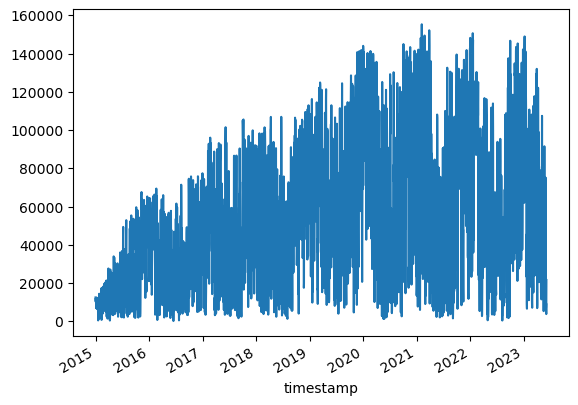

In [39]:
region = 'DE'
resolution = 'day'
# Date from 1.1.2015 to 1.1.2023
timestamps = ['1420066800000','1451602800000','1483225200000','1514761200000','1546297200000', '1577833200000', '1609455600000', '1640991600000', '1672527600000']
filterlist = ['1223', '1224', '1225', '1226', '1227', '1228', '4066', '4067', '4068', '4069', '4070', '4071', '410', '4359', '4387']
namelist = ['Braunkohle', 'Kernenergie', 'wind offshore', 'Wasserkraft', 'Sonstige Konventionelle', 'Sonstige Erneuerbare', 'Biomasse', 'Wind Onshore', 'Photovoltaik', 'Steinkohle', 'Pumpspeicher', 'Erdgas', 'Gesamt (Netzlast)', 'Residuallast', 'Stromerzeugung']

# creating main dataframe
de_complete = pd.DataFrame()
de_complete.insert(0, 'timestamp', [])
for name in namelist:
    de_complete.insert(namelist.index(name)+1, name, [])

# loop over the timestamps and get the data for each timestamp (as data only gives the data for one year)
for timestamp in timestamps:
    print("timestamp: " + timestamp)
    df = pd.DataFrame()
    df.insert(0, 'timestamp', [])
    # loop over the filterlist and get the data for each filter
    for filter in filterlist:
        data = get_smard_data(filter,region,resolution, timestamp)
        #print("temporarily created df: " + namelist[filterlist.index(filter) ])
        df2 = pd.DataFrame(data['series'])
        df2.columns = df2.columns = ['timestamp', namelist[filterlist.index(filter)]]
        df = pd.merge(df, df2, on='timestamp', how='outer')
    # append the dataframes for each timestamp
    de_complete = pd.concat([de_complete, df])
de_complete.head()

# make timestamp column to datetime for better readability
de_complete['timestamp'] = pd.to_datetime(de_complete['timestamp'], unit='ms')
de_complete = de_complete.set_index('timestamp')
de_complete['wind offshore'].plot()
#de_complete.to_csv('../Data/smard_de_generation_data_2015_2023.csv')

### 2.3 Austria: electricity generation data from smard

#### 2.3.1 query data 

timestamp: 1420066800000
timestamp: 1451602800000
timestamp: 1483225200000
timestamp: 1514761200000
timestamp: 1546297200000
timestamp: 1577833200000
timestamp: 1609455600000
timestamp: 1640991600000
timestamp: 1672527600000


<AxesSubplot:xlabel='timestamp'>

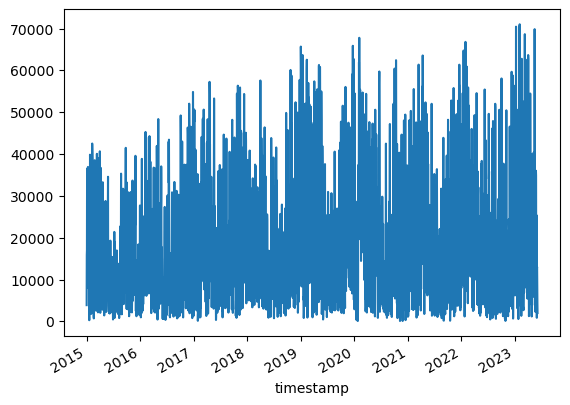

In [40]:
region = 'AT'
resolution = 'day'
# Date from 1.1.2015 to 1.1.2023
timestamps = ['1420066800000','1451602800000','1483225200000','1514761200000','1546297200000', '1577833200000', '1609455600000', '1640991600000', '1672527600000']
filterlist = ['4066','1226','4067','4068', '1228', '4069','4071','4070','1227']
namelist = ['Biomasse','Wasserkraft','Wind Onshore','Photovoltaik','Sonstige Erneuerbare','Steinkohle','Erdgas','Pumpspeicher','Sonstige Konventionelle']
# creating main dataframe
at_complete = pd.DataFrame()
at_complete.insert(0, 'timestamp', [])
for name in namelist:
    at_complete.insert(namelist.index(name)+1, name, [])

# loop over the timestamps and get the data for each timestamp (as data only gives the data for one year)
for timestamp in timestamps:
    print("timestamp: " + timestamp)
    df = pd.DataFrame()
    df.insert(0, 'timestamp', [])
    # loop over the filterlist and get the data for each filter
    for filter in filterlist:
        data = get_smard_data(filter,region,resolution, timestamp)
        #print("temporarily created df: " + namelist[filterlist.index(filter)])
        df2 = pd.DataFrame(data['series'])
        df2.columns = df2.columns = ['timestamp', namelist[filterlist.index(filter)]]
        df = pd.merge(df, df2, on='timestamp', how='outer')
    # append the dataframes for each timestamp
    at_complete = pd.concat([at_complete, df]) 
at_complete.head()

# make timestamp column to datetime for better readability
at_complete['timestamp'] = pd.to_datetime(at_complete['timestamp'], unit='ms')
at_complete = at_complete.set_index('timestamp')
at_complete['Wind Onshore'].plot()
#at_complete.to_csv('../Data/smard_at_generation_data_2015_2023.csv')

#### 2.3.2 add corresponding CO2 intensity for Germany and Austria
- corresponding energy types in co2_intensity table
    - use same category for 'Braunkohle' and 'Steinkohle' as 'coal'
    - Sonstige Erneuerbare': include Erdwärme, Deponiegas, Klärgas, Grubengas
    - Sonstige Konventionelle: 
        - Abgeleitetes Gas aus Kohle, Mineralöl, Abfall, Gichtgas, Hochofengas, Raffineriegas, 
        - Gas mit hohem Wasserstoffanteil, sonstige Reststoffe aus der Produktion (z.B. Stahl- und Kokserzeugung),
        - Gemische aus mehreren Brennstoffen
    - 'Photovoltaik': 'solarPV polySi ground-mounted'
        - Because Fraunhofer reported the most commenly used type of solar panel in Germany is ground mounted poly-Si solar panels 
    - 'Pumpspeicher': 'hydro'. It is same as HYDRO_WATER_RESERVOIR in rte data.
        - Here I will convert the value to negatvie, as in rte data. 
    - 'Sonstige Konventionelle': not found co2 emission, temporarily use the mean of coal, gas, oil and waste (mean = 645)
        - Derived gas from coal, mineral oil, Waste, blast furnace gas, blast furnace gas, refinery gas, Gas with high hydrogen content, other residues from production (e.g. steel and coke production), Mixtures of several fuels
        - They are conventional power plants that are not classified as hard coal, lignite, natural gas, or oil
    - 'Sonstige Erneuerbare': use methane gas (400), because 3 types in this category are methane gas, though geothermal has low emission
        - Geothermal energy (38), landfill gas, sewage gas, mine gas (the three gas types primarily composed of methane (CH4) )
        - renewable energy sources in Germany that are not classified as wind, solar, hydropower, or bioenergy. 

In [41]:
smard_de = de_complete.copy().dropna(how='all').reset_index().drop(['Gesamt (Netzlast)','Residuallast',	'Stromerzeugung'], axis=1)
smard_at = at_complete.copy().dropna(how='all').reset_index()
# convert Pumpspeicher to negative values
smard_de['Pumpspeicher'] = smard_de['Pumpspeicher']* (-1)
smard_de = pd.melt(smard_de, id_vars='timestamp', var_name='production_type', value_name='value').dropna(subset=['value'])
smard_at['Pumpspeicher'] = smard_at['Pumpspeicher']* (-1)
smard_at = pd.melt(smard_at, id_vars='timestamp', var_name='production_type', value_name='value').dropna(subset=['value'])

# change the timestamp to the form of year-month-day, as there is only one time point per day
smard_de['timestamp'] = pd.to_datetime(smard_de['timestamp'])
smard_de['date'] = smard_de['timestamp'].dt.strftime('%Y-%m-%d')
smard_de.drop('timestamp', axis=1, inplace=True)
smard_at['timestamp'] = pd.to_datetime(smard_at['timestamp'])
smard_at['date'] = smard_at['timestamp'].dt.strftime('%Y-%m-%d')
smard_at.drop('timestamp', axis=1, inplace=True)
smard_de

,production_type,value,date
0,Braunkohle,314599.00,2014-12-31
1,Braunkohle,257344.00,2015-01-01
2,Braunkohle,296727.50,2015-01-02
3,Braunkohle,287900.50,2015-01-03
4,Braunkohle,405171.25,2015-01-04
...,...,...,...
36954,Erdgas,114827.50,2023-06-01
36955,Erdgas,80401.00,2023-06-02
36956,Erdgas,76580.75,2023-06-03
36957,Erdgas,165349.25,2023-06-04


In [42]:
# add co2 emission: gCO2eq/kWh column        
production_type = smard_de.production_type.unique()
source_de = ['de coal', 'de nuclear', 'wind offshore', 'de hydro','other conventional','other renewables','biomass','wind onshore',
          'solarPV polySi ground-mounted','coal','de hydro','natural gas']
source_at = ['coal', 'nuclear', 'wind offshore', 'hydro','other conventional','other renewables','biomass','wind onshore',
          'solarPV polySi ground-mounted','coal','hydro','natural gas']
# new column to map source names
mapping_dict_de = dict(zip(production_type, source_de))
smard_de['source'] = smard_de['production_type'].map(mapping_dict_de)
# add gCO2eq/kWh to indicate co2 emission per unit electricity generation
smard_de = pd.merge(smard_de, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)

mapping_dict_at = dict(zip(production_type, source_at))
smard_at['source'] = smard_at['production_type'].map(mapping_dict_at)
# add gCO2eq/kWh to indicate co2 emission per unit electricity generation
smard_at = pd.merge(smard_at, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)
# calculate total co2 emission for each row
smard_de['total_gCO2eq'] = smard_de['value']*1000*smard_de['gCO2eq/kWh']
smard_at['total_gCO2eq'] = smard_at['value']*1000*smard_at['gCO2eq/kWh']
smard_de

,production_type,value,date,source,gCO2eq/kWh,total_gCO2eq
0,Braunkohle,314599.00,2014-12-31,de coal,1080.0,3.397669e+11
1,Braunkohle,257344.00,2015-01-01,de coal,1080.0,2.779315e+11
2,Braunkohle,296727.50,2015-01-02,de coal,1080.0,3.204657e+11
3,Braunkohle,287900.50,2015-01-03,de coal,1080.0,3.109325e+11
4,Braunkohle,405171.25,2015-01-04,de coal,1080.0,4.375850e+11
...,...,...,...,...,...,...
36949,Erdgas,114827.50,2023-06-01,natural gas,490.0,5.626548e+10
36950,Erdgas,80401.00,2023-06-02,natural gas,490.0,3.939649e+10
36951,Erdgas,76580.75,2023-06-03,natural gas,490.0,3.752457e+10
36952,Erdgas,165349.25,2023-06-04,natural gas,490.0,8.102113e+10


#### 2.3.3 calculate the total gCO2eq of each row, and use it to further calculate the CO2 intensity of the electricity mix 

In [43]:
# sum up co2 emission for each day, and divide by the total electricity generation value to get the average co2 emission per kWh
smard_de_total = smard_de.groupby(['date']).sum().reset_index().drop(['gCO2eq/kWh'], axis=1) # drop the gCO2eq/kWh of each technology
smard_de_total['gCO2eq/kWh'] = smard_de_total['total_gCO2eq']/(smard_de_total['value']*1000) # calculate gCO2eq/kWh of the mixed electricity generation

smard_at_total = smard_at.groupby(['date']).sum().reset_index().drop(['gCO2eq/kWh'], axis=1) # drop the gCO2eq/kWh of each technology
smard_at_total['gCO2eq/kWh'] = smard_at_total['total_gCO2eq']/(smard_at_total['value']*1000) # calculate gCO2eq/kWh of the mixed electricity generation
smard_de_total

,date,production_type,value,source,total_gCO2eq,gCO2eq/kWh
0,2014-12-31,BraunkohleKernenergiewind offshoreWasserkraftS...,1215382.25,de coalde nuclearwind offshorede hydroother co...,5.195221e+11,427.455718
1,2015-01-01,BraunkohleKernenergiewind offshoreWasserkraftS...,1448501.25,de coalde nuclearwind offshorede hydroother co...,4.908844e+11,338.891246
2,2015-01-02,BraunkohleKernenergiewind offshoreWasserkraftS...,1352439.50,de coalde nuclearwind offshorede hydroother co...,5.090432e+11,376.388916
3,2015-01-03,BraunkohleKernenergiewind offshoreWasserkraftS...,1267112.75,de coalde nuclearwind offshorede hydroother co...,4.850171e+11,382.773405
4,2015-01-04,BraunkohleKernenergiewind offshoreWasserkraftS...,1458238.75,de coalde nuclearwind offshorede hydroother co...,7.700956e+11,528.099801
...,...,...,...,...,...,...
3075,2023-06-02,BraunkohleKernenergiewind offshoreWasserkraftS...,917474.00,de coalde nuclearwind offshorede hydroother co...,2.353024e+11,256.467676
3076,2023-06-03,BraunkohleKernenergiewind offshoreWasserkraftS...,843248.75,de coalde nuclearwind offshorede hydroother co...,2.353015e+11,279.041645
3077,2023-06-04,BraunkohleKernenergiewind offshoreWasserkraftS...,913088.75,de coalde nuclearwind offshorede hydroother co...,3.022453e+11,331.014179
3078,2023-06-05,BraunkohleKernenergiewind offshoreWasserkraftS...,920724.00,de coalde nuclearwind offshorede hydroother co...,3.539187e+11,384.391747


## 2.4 Italy: electricity generation data from Terna 
### 2.4.1 query data
- Accessing API with Token and generating data in steps of 60 days
- data updated every hour

In [44]:
# API endpoint URL
url = 'https://api.terna.it/transparency/v1.0/getactualgeneration'
# Key and Secred for the API, generated by creating an account and appilication on the website
apiKey = 'v72ftysuzm8yegdh7ghyrjck'
apiSecret = 'RYu57mcpxn'
# Generate the token using the key and secret
tokenurl = 'https://api.terna.it/transparency/oauth/accessToken'
tokendata = {
    'client_id': 'v72ftysuzm8yegdh7ghyrjck',
    'client_secret': 'RYu57mcpxn',
    'grant_type': 'client_credentials'
}

tokenheaders = {'Content-Type': 'application/x-www-form-urlencoded'}
response = requests.post(tokenurl, data=tokendata, headers=tokenheaders)
access_token = json.loads(response.content.decode('utf-8'))['access_token']

# loop for the dates so that it makes 60 day steps until today
datelist = pd.date_range(start="2018-01-01",end=datetime.now().strftime("%Y-%m-%d"), freq='60D').tolist()
datelist = [datetime.strftime(date, "%d/%m/%Y") for date in datelist]
# sleeps are entered because the API only allows 1 request per second
time.sleep(1)
df_italy = pd.DataFrame()

for i in range(len(datelist)-1):
    params = {
        "dateFrom": datelist[i],
        "dateTo": datelist[i+1]
    }
    if response.status_code == 200:
        headers = {'Authorization': f'Bearer {access_token}'}
        response = requests.get(url, headers=headers, params=params)
        print(response.status_code)
        data = response.json()
        df_italytemp = pd.DataFrame(data['actualGeneration'])
        #df_italy = df_italy.append(df_italytemp)
        df_italy = pd.concat([df_italy, df_italytemp])
    else:
        print('Failed to generate token' + str(response.text))
    # sleep because of Qps limit
    time.sleep(1)
print(df_italy.head())

KeyError: 'access_token'

In [ ]:
#export to csv
df_italy.to_csv('../Data/italy_actual_generation.csv', index=False)

### 2.4.2 add corresponding CO2 intensity 

- corresponding energy types in co2_intensity table
    - thermal: use natural gas (490) in co2_intensity table. Because thermal power plants in Italy utilize a combination of **natural gas, coal, and oil** to produce electricity. **Natural gas-fired** power plants are the **most prevalent** and have been favored due to their relatively lower carbon emissions compared to coal and oil.
    - Hydro: 24 gCO2/kWh, hydrop as in co2_intensity table
    - Geothermal: 38 gCO2/kWh
    - Photovoltaic: solar photovoltaic or solar PV. In Italy, both utility-scale (48) and rooftop solar PV (41) systems are commonly used. So let's use the average of the two --> 44.5 gCO2/kWh
    - Wind: primary focus for wind energy generation is onshore wind farms. So we will take wind onshore in co2_intensity table

In [45]:
#terna_it = df_italy.copy()
terna_it = pd.read_csv('../Data/italy_actual_generation.csv')
# change the timestamp to the form of year-month-day
terna_it['Date'] = pd.to_datetime(terna_it['Date'])
terna_it['Actual_Generation_GWh'] = terna_it['Actual_Generation_GWh'].astype(float)
# sum up the generation quantity by Date&Primary_Source
terna_it = terna_it.groupby(['Date','Primary_Source']).sum().reset_index()
# convert the generation unit from GWh to MWh as the data of other three countries
terna_it['Actual_Generation_MWh'] = terna_it['Actual_Generation_GWh'] * 1000
# drop the Actual_Generation_GWh column
terna_it = terna_it.drop('Actual_Generation_GWh', axis=1)
# drop the 'Self-consumption' from Primary_Source attribute, because it is not a generation source type
terna_it = terna_it[terna_it['Primary_Source']!='Self-consumption']
terna_it

,Date,Primary_Source,Actual_Generation_MWh
0,2018-01-01 00:00:00,Geothermal,660.0
1,2018-01-01 00:00:00,Hydro,1710.0
2,2018-01-01 00:00:00,Photovoltaic,0.0
4,2018-01-01 00:00:00,Thermal,13910.0
5,2018-01-01 00:00:00,Wind,3620.0
...,...,...,...
285264,2023-06-04 23:00:00,Geothermal,600.0
285265,2023-06-04 23:00:00,Hydro,8220.0
285266,2023-06-04 23:00:00,Photovoltaic,0.0
285268,2023-06-04 23:00:00,Thermal,10990.0


In [46]:
# add co2 emission: gCO2eq/kWh column        
production_type = ['Thermal', 'Hydro', 'Geothermal', 'Photovoltaic', 'Wind']
source = ['natural gas','hydro','geothermal','solarPV rooftop&utilityscale','wind onshore']
co2_intensity_it = [490,24,38,44.5,12]
# map co2 intensity to the corresponding source
mapping_dict_it = dict(zip(production_type, co2_intensity_it))
# map new source names
mapping_dict_it2 = dict(zip(production_type, source))
terna_it['gCO2eq/kWh'] = terna_it['Primary_Source'].map(mapping_dict_it)
terna_it['source'] = terna_it['Primary_Source'].map(mapping_dict_it2)
terna_it = terna_it.drop('Primary_Source',axis=1)
terna_it

,Date,Actual_Generation_MWh,gCO2eq/kWh,source
0,2018-01-01 00:00:00,660.0,38.0,geothermal
1,2018-01-01 00:00:00,1710.0,24.0,hydro
2,2018-01-01 00:00:00,0.0,44.5,solarPV rooftop&utilityscale
4,2018-01-01 00:00:00,13910.0,490.0,natural gas
5,2018-01-01 00:00:00,3620.0,12.0,wind onshore
...,...,...,...,...
285264,2023-06-04 23:00:00,600.0,38.0,geothermal
285265,2023-06-04 23:00:00,8220.0,24.0,hydro
285266,2023-06-04 23:00:00,0.0,44.5,solarPV rooftop&utilityscale
285268,2023-06-04 23:00:00,10990.0,490.0,natural gas


### 2.4.3 calculate the total gCO2eq of each row, and use it to further calculate the CO2 intensity of the electricity mix 

In [47]:
# italy total generation per day
it_total = terna_it.copy()
# calculate total co2 emission for each row
it_total['total_gCO2eq'] = it_total['Actual_Generation_MWh']*1000*it_total['gCO2eq/kWh']
# convert date to y-m-d
it_total['Date'] = it_total['Date'].dt.strftime('%Y-%m-%d')
it_total = it_total.groupby('Date').sum().reset_index().drop(['source','gCO2eq/kWh'],axis=1)
it_total['gCO2eq/kWh'] = it_total['total_gCO2eq']/(it_total['Actual_Generation_MWh']*1000)
it_total['country'] = 'Italy'
it_total

,Date,Actual_Generation_MWh,total_gCO2eq,gCO2eq/kWh,country
0,2018-01-01,528710.0,1.583458e+11,299.494647,Italy
1,2018-01-02,613710.0,1.834748e+11,298.960136,Italy
2,2018-01-03,660540.0,2.068421e+11,313.140854,Italy
3,2018-01-04,648010.0,2.121619e+11,327.405225,Italy
4,2018-01-05,640320.0,2.137443e+11,333.808619,Italy
...,...,...,...,...,...
1976,2023-05-31,624720.0,1.721520e+11,275.566678,Italy
1977,2023-06-01,598980.0,1.626503e+11,271.545527,Italy
1978,2023-06-02,507960.0,1.168311e+11,230.000600,Italy
1979,2023-06-03,495820.0,1.107116e+11,223.289863,Italy


### 2.5 Concat all four countries data in one df

#### 2.5.1 concat the generation mix data of four countries

In [48]:
# DE & AT
de_total = smard_de_total.copy().iloc[1:,:] # start from 2015-01-01
de_total = de_total.drop(['production_type','source'],axis=1)
de_total['country'] = 'Germany'
at_total = smard_at_total.copy().iloc[1:,:] # start from 2015-01-01
at_total = at_total.drop(['production_type','source'],axis=1)
at_total['country'] = 'Austria'
# FR
fr_total = rte_fr_total.drop('production_type',axis=1)
fr_total['date'] = fr_total['start_date'].str[:10]
fr_total.drop(['start_date','end_date','source'], axis=1, inplace=True)
fr_total = fr_total.groupby(['date']).sum()
fr_total['gCO2eq/kWh'] = fr_total['gco2eq']/(fr_total['value']*1000)
fr_total['country'] = 'France'
fr_total.reset_index(inplace=True)
fr_total.columns = ['date', 'value', 'gCO2eq/kWh', 'total_gCO2eq','country']
# IT
it_total.columns = ['date',	'value','total_gCO2eq',	'gCO2eq/kWh','country']
# concatenate the dataframes
de_at_fr_it_total_generation_data_2015_2023 = pd.concat([de_total, at_total, fr_total,it_total], axis=0)
de_at_fr_it_total_generation_data_2015_2023.columns = ['date', 'total_generation(MWh)', 'total_gCO2eq', 'gCO2eq/kWh', 'country']
de_at_fr_it_total_generation_data_2015_2023.to_csv('../Data/de_at_fr_it_total_generation_data_2015_2023.csv')
de_at_fr_it_total_generation_data_2015_2023

,date,total_generation(MWh),total_gCO2eq,gCO2eq/kWh,country
1,2015-01-01,1448501.25,4.908844e+11,338.891246,Germany
2,2015-01-02,1352439.50,5.090432e+11,376.388916,Germany
3,2015-01-03,1267112.75,4.850171e+11,382.773405,Germany
4,2015-01-04,1458238.75,7.700956e+11,528.099801,Germany
5,2015-01-05,1473746.00,8.679044e+11,588.910445,Germany
...,...,...,...,...,...
1976,2023-05-31,624720.00,1.721520e+11,275.566678,Italy
1977,2023-06-01,598980.00,1.626503e+11,271.545527,Italy
1978,2023-06-02,507960.00,1.168311e+11,230.000600,Italy
1979,2023-06-03,495820.00,1.107116e+11,223.289863,Italy


#### 2.5.2 concat the generation per source data

In [49]:
fr_type = rte_2015_2023_types.copy()
fr_type['date'] = fr_type['start_date'].str[:10]
fr_type.drop(['start_date','end_date','production_type','gCO2eq/kWh'], axis=1, inplace=True)
fr_type = fr_type.groupby(['date','source']).sum().reset_index()
# add gCO2eq/kWh (by production type) to indicate co2 emission per unit electricity generation
fr_type = pd.merge(fr_type, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)
fr_type.columns = ['date', 'source', 'value', 'total_gCO2eq', 'gCO2eq/kWh']
fr_type = pd.merge(fr_type, fr_total, how='left', on='date')
fr_type['proportion_electr_generation'] = fr_type['value_x']/fr_type['value_y']*100
fr_type = fr_type[['date', 'source', 'value_x', 'proportion_electr_generation', 'gCO2eq/kWh_x', 'total_gCO2eq_x', 'country']]
fr_type.columns = ['date', 'source', 'value', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
fr_type

,date,source,value,proportion_electr_generation,gCO2eq/kWh,total_gCO2eq,country
0,2015-01-01,biomass,4813,0.278905,230.0,1.106990e+09,France
1,2015-01-01,fr coal,27268,1.580131,1090.0,2.972212e+10,France
2,2015-01-01,fr hydro,177877,10.307647,20.0,3.557540e+09,France
3,2015-01-01,fr nuclear,1384251,80.214814,10.0,1.384251e+10,France
4,2015-01-01,natural gas,58190,3.372004,490.0,2.851310e+10,France
...,...,...,...,...,...,...,...
27103,2023-05-27,natural gas,29120,2.609906,490.0,1.426880e+10,France
27104,2023-05-27,oil,4131,0.370245,777.0,3.209787e+09,France
27105,2023-05-27,solarPV rooftop,109534,9.817083,41.0,4.490894e+09,France
27106,2023-05-27,waste,3004,0.269236,494.0,1.483976e+09,France


In [50]:
de_type = smard_de.copy()
de_type.drop(['production_type'], axis=1, inplace=True)
de_type = pd.merge(de_type, de_total, how='left', on='date')
de_type['proportion_electr_generation'] = de_type['value_x']/de_type['value_y']*100
de_type = de_type[['date', 'source', 'value_x', 'proportion_electr_generation', 'gCO2eq/kWh_x', 'total_gCO2eq_x', 'country']]
de_type.columns = ['date', 'source', 'value', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
de_type = de_type.dropna(subset = ['proportion_electr_generation'])
# AT
at_type = smard_at.copy()
at_type.drop(['production_type'], axis=1, inplace=True)
at_type = pd.merge(at_type, at_total, how='left', on='date')
at_type['proportion_electr_generation'] = at_type['value_x']/at_type['value_y']*100
at_type = at_type[['date', 'source', 'value_x', 'proportion_electr_generation', 'gCO2eq/kWh_x', 'total_gCO2eq_x', 'country']]
at_type.columns = ['date', 'source', 'value', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
at_type = at_type.dropna(subset = ['proportion_electr_generation'])
at_type

,date,source,value,proportion_electr_generation,gCO2eq/kWh,total_gCO2eq,country
1,2015-01-01,biomass,7226.0,6.169635,230.0,1.661980e+09,Austria
2,2015-01-02,biomass,7297.0,6.486366,230.0,1.678310e+09,Austria
3,2015-01-03,biomass,7339.0,5.278337,230.0,1.687970e+09,Austria
4,2015-01-04,biomass,7339.0,4.493515,230.0,1.687970e+09,Austria
5,2015-01-05,biomass,7392.0,5.211377,230.0,1.700160e+09,Austria
...,...,...,...,...,...,...,...
27705,2023-06-01,other conventional,2928.0,2.038075,645.0,1.888560e+09,Austria
27706,2023-06-02,other conventional,2928.0,1.922856,645.0,1.888560e+09,Austria
27707,2023-06-03,other conventional,2928.0,2.106460,645.0,1.888560e+09,Austria
27708,2023-06-04,other conventional,2928.0,2.276810,645.0,1.888560e+09,Austria


In [51]:
it_type = terna_it.copy()
it_type['date'] = it_type['Date'].dt.strftime('%Y-%m-%d')
it_type = it_type.drop('Date',axis=1)
it_type = it_type.groupby(['date','source','gCO2eq/kWh']).sum().reset_index()
it_type['total_gCO2eq'] = it_type['gCO2eq/kWh']*it_type['Actual_Generation_MWh']*1000
it_type['country'] = 'Italy'
it_type = pd.merge(it_type, it_total[['date','value']], how='left', on='date')
it_type['proportion_electr_generation'] = it_type['Actual_Generation_MWh']/it_type['value']*100
it_type = it_type.drop('value',axis=1)
it_type.columns = ['date', 'source', 'gCO2eq/kWh', 'value', 'total_gCO2eq','country','proportion_electr_generation']
it_type

,date,source,gCO2eq/kWh,value,total_gCO2eq,country,proportion_electr_generation
0,2018-01-01,geothermal,38.0,15940.0,6.057200e+08,Italy,3.014885
1,2018-01-01,hydro,24.0,60620.0,1.454880e+09,Italy,11.465643
2,2018-01-01,natural gas,490.0,314880.0,1.542912e+11,Italy,59.556278
3,2018-01-01,solarPV rooftop&utilityscale,44.5,10670.0,4.748150e+08,Italy,2.018120
4,2018-01-01,wind onshore,12.0,126600.0,1.519200e+09,Italy,23.945074
...,...,...,...,...,...,...,...
9900,2023-06-04,geothermal,38.0,14760.0,5.608800e+08,Italy,3.089935
9901,2023-06-04,hydro,24.0,166920.0,4.006080e+09,Italy,34.943895
9902,2023-06-04,natural gas,490.0,206410.0,1.011409e+11,Italy,43.210936
9903,2023-06-04,solarPV rooftop&utilityscale,44.5,76630.0,3.410035e+09,Italy,16.042120


In [52]:
de_at_fr_it_type_generation_data_2015_2023 = pd.concat([de_type, at_type, fr_type,it_type], axis=0)
de_at_fr_it_type_generation_data_2015_2023.columns = ['date', 'source', 'total_generation(MWh)', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
de_at_fr_it_type_generation_data_2015_2023.to_csv('../Data/de_at_fr_it_type_generation_data_2015_2023.csv')
de_at_fr_it_type_generation_data_2015_2023

,date,source,total_generation(MWh),proportion_electr_generation,gCO2eq/kWh,total_gCO2eq,country
1,2015-01-01,de coal,257344.00,17.766226,1080.0,2.779315e+11,Germany
2,2015-01-02,de coal,296727.50,21.940168,1080.0,3.204657e+11,Germany
3,2015-01-03,de coal,287900.50,22.720985,1080.0,3.109325e+11,Germany
4,2015-01-04,de coal,405171.25,27.784973,1080.0,4.375850e+11,Germany
5,2015-01-05,de coal,423603.75,28.743335,1080.0,4.574920e+11,Germany
...,...,...,...,...,...,...,...
9900,2023-06-04,geothermal,14760.00,3.089935,38.0,5.608800e+08,Italy
9901,2023-06-04,hydro,166920.00,34.943895,24.0,4.006080e+09,Italy
9902,2023-06-04,natural gas,206410.00,43.210936,490.0,1.011409e+11,Italy
9903,2023-06-04,solarPV rooftop&utilityscale,76630.00,16.042120,44.5,3.410035e+09,Italy


## 3 market electricity price from smard
### 3.1 load market price data of DE, CH, AT, IT, FR

In [53]:
region = 'DE'
resolution = 'day'
# Attention, different timestamps than before, because the data is not available for the whole time period
timestamps = ['1514761200000','1546297200000','1577833200000','1609455600000','1640991600000', '1672527600000']
filterlist = ['4169','259','4170','255','254']
namelist = ['Marktpreis_deutschland', 'Marktpreis_Schweiz', 'Marktpreis_Österreich', 'Marktpreis_Italien_Nord','Marktpreis_Frankreich']

df_complete_price = pd.DataFrame()
df_complete_price.insert(0, 'timestamp', [])
for name in namelist:
    df_complete_price.insert(namelist.index(name)+1, name, [])

# loop over the timestamps and get the data for each timestamp
for timestamp in timestamps:
    print("timestamp: " + timestamp)
    df = pd.DataFrame()
    df.insert(0, 'timestamp', [])
    # loop over the filterlist and get the data for each filter
    for filter in filterlist:
        data = get_smard_data(filter,region,resolution, timestamp)
        print("temporarily created df: " + namelist[filterlist.index(filter)])
        df2 = pd.DataFrame(data['series'])
        df2.columns = df2.columns = ['timestamp', namelist[filterlist.index(filter)]]
        df = pd.merge(df, df2, on='timestamp', how='outer')
    df_complete_price = pd.concat([df_complete_price, df], ignore_index=True)
df_complete_price.head()

timestamp: 1514761200000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Marktpreis_Frankreich
timestamp: 1546297200000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Marktpreis_Frankreich
timestamp: 1577833200000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Marktpreis_Frankreich
timestamp: 1609455600000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Ma

,timestamp,Marktpreis_deutschland,Marktpreis_Schweiz,Marktpreis_Österreich,Marktpreis_Italien_Nord,Marktpreis_Frankreich
0,1.514761e+12,NaN,17.12,NaN,45.34,2.66
1,1.514848e+12,NaN,45.09,NaN,39.96,32.25
2,1.514934e+12,NaN,47.84,NaN,52.24,16.52
3,1.515020e+12,NaN,47.89,NaN,42.84,30.70
4,1.515107e+12,NaN,44.32,NaN,51.38,34.01


<AxesSubplot:xlabel='timestamp'>

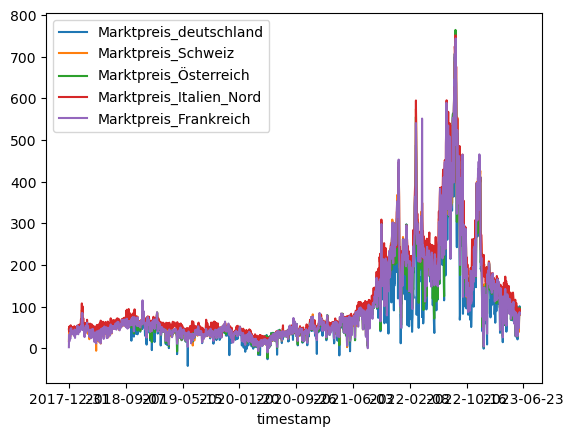

In [54]:
# make timestamp column to datetime, and keep it to the form of 2017-12-31
df_complete_price['timestamp'] = pd.to_datetime(df_complete_price['timestamp'], unit='ms')
#df_complete_price['timestamp'] = pd.to_datetime(df_complete_price['timestamp'])
df_complete_price['timestamp'] = df_complete_price['timestamp'].dt.strftime('%Y-%m-%d')
df_complete_price.to_csv('../Data/market_price_data_five_countries.csv', index=False)
df_complete_price = df_complete_price.set_index('timestamp')
#df_complete_price = df_complete_price.set_index('timestamp')
df_complete_price.plot()

In [55]:
# convert to long table and save locally
df_complete_price_long = pd.read_csv('../Data/market_price_data_five_countries.csv')
df_complete_price_long.columns = ['date','Germany','Switzerland','Austria','Italy','France']
df_complete_price_long = pd.melt(df_complete_price_long, id_vars=['date'], var_name='country', value_name='market_price(€/MWh))')
df_complete_price_long

,date,country,market_price(€/MWh))
0,2017-12-31,Germany,NaN
1,2018-01-01,Germany,NaN
2,2018-01-02,Germany,NaN
3,2018-01-03,Germany,NaN
4,2018-01-04,Germany,NaN
...,...,...,...
10950,2023-12-26,France,NaN
10951,2023-12-27,France,NaN
10952,2023-12-28,France,NaN
10953,2023-12-29,France,NaN


### 3.2 join the co2 emission intensity of the electricity mix per country per day

In [56]:
de_at_fr_it_total_generation_data_2015_2023 = pd.read_csv('../Data/de_at_fr_it_total_generation_data_2015_2023.csv').iloc[:,1:]
co2_intensity_country_day = de_at_fr_it_total_generation_data_2015_2023[['date','gCO2eq/kWh','country']]

In [57]:
df_complete_price_long = df_complete_price_long.merge(co2_intensity_country_day, on=['date','country'], how='left').dropna(how='any')
df_complete_price_long.to_csv('../Data/market_price_data_five_countries_long.csv', index=False)
df_complete_price_long

,date,country,market_price(€/MWh)),gCO2eq/kWh
273,2018-09-30,Germany,61.24,490.343800
274,2018-10-01,Germany,42.34,350.354633
275,2018-10-02,Germany,18.29,284.389111
276,2018-10-03,Germany,65.15,512.735542
277,2018-10-04,Germany,60.30,489.803669
...,...,...,...,...
10733,2023-05-23,France,83.20,29.845545
10734,2023-05-24,France,71.84,31.882727
10735,2023-05-25,France,63.47,31.760818
10736,2023-05-26,France,59.25,31.468713


## 4 import export electricity data of Switzerland

In [58]:
url = 'https://www.uvek-gis.admin.ch/BFE/ogd/35/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv'
r = requests.get(url, allow_redirects=True)
open('../Data/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv', 'wb').write(r.content)
df_electricity_data_ch = pd.read_csv('../Data/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv', header=0, index_col=0, parse_dates=True, sep=',')

#df_electricity_data_ch = pd.read_csv('../Data/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv', header=0, index_col=0, parse_dates=True, squeeze=True, sep=',')

In [59]:
df_electricity_data_ch.reset_index(inplace=True)
# make the column Jahr equal a string aggregation from the first 4 characters of the column Jahr puls the value of column month plus a '01'
df_electricity_data_ch['Jahr'] = df_electricity_data_ch['Jahr'].astype(str).str[:4] + df_electricity_data_ch['Monat'].astype(str).str.zfill(2) + '01'
# convert the column Jahr to a datetime object
df_electricity_data_ch['Jahr'] = pd.to_datetime(df_electricity_data_ch['Jahr'], format='%Y%m%d')
# set the column Jahr as index
df_electricity_data_ch.set_index('Jahr', inplace=True)
# drop the column Monat
df_electricity_data_ch.drop('Monat', axis=1, inplace=True)

df_electricity_data_ch_export = df_electricity_data_ch.copy()
df_electricity_data_ch_export.reset_index(inplace=True)
df_electricity_data_ch_export.to_csv('../Data/df_electricity_data_ch_edited.csv')

# show head of the dataframe
df_electricity_data_ch.head()

,Definitiv,Erzeugung_laufwerk_GWh,Erzeugung_speicherwerk_GWh,Erzeugung_kernkraftwerk_GWh,Erzeugung_andere_GWh,Verbrauch_speicherpumpen_GWh,Erzeugung_netto_GWh,Einfuhr_GWh,Ausfuhr_GWh,Landesverbrauch_GWh,Verluste_GWh,Endverbrauch_GWh
Jahr,,,,,,,,,,,,
2000-01-01,1,891,2004,2354,238,72,5415,2580,2521,5474,346,5128
2000-02-01,1,959,1516,2213,232,40,4880,2478,2337,5021,353,4668
2000-03-01,1,1069,1463,2355,229,44,5072,2608,2596,5084,347,4737
2000-04-01,1,1196,1068,2278,218,139,4621,2181,2375,4427,334,4093
2000-05-01,1,2060,1920,2307,197,228,6256,1212,3034,4434,315,4119


In [60]:
url = 'https://pubdb.bfe.admin.ch/de/publication/download/9333'
r = requests.get(url, allow_redirects=True)
open('../Data/aussenhandel_schweiz.xlsx', 'wb').write(r.content)

file_path = '../Data/aussenhandel_schweiz.xlsx'
workbook = load_workbook(file_path)
sheet = workbook.worksheets[0]
rows_to_delete = [1, 2, 3, 4, 5, 6, 7,9] 

for row in reversed(rows_to_delete):  # Delete rows in reverse order to avoid index shifting
    sheet.delete_rows(row)

# Delete columns (e.g. columns U to AM)
columns_to_delete = ['AM', 'AL', 'AK', 'AJ', 'AI', 'AH', 'AG', 'AF', 'AE', 'AD', 'AC', 'AB', 'AA', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G']

for col in columns_to_delete:
    col_index = column_index_from_string(col)  # Convert column letter to integer index
    sheet.delete_cols(col_index, 1)

workbook.save('../Data/import.xlsx')

In [61]:
workbook = load_workbook(file_path)
sheet = workbook.worksheets[0]
rows_to_delete = [1, 2, 3, 4, 5, 6, 7, 9] 

for row in reversed(rows_to_delete):  # Delete rows in reverse order to avoid index shifting
    sheet.delete_rows(row)

# Delete columns (e.g. columns U to AM)
columns_to_delete = ['AM', 'AL', 'AK', 'AJ', 'AI', 'AH', 'AG', 'AF', 'AE', 'AD', 'AC', 'AB', 'AA', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']

for col in columns_to_delete:
    col_index = column_index_from_string(col)  # Convert column letter to integer index
    sheet.delete_cols(col_index, 1)

workbook.save('../Data/export.xlsx')

# load import outport data
df_import = pd.read_excel('../Data/import.xlsx')
df_export = pd.read_excel('../Data/export.xlsx')

#rename the first columns of the dataframes to 'Datum'
df_import.rename(columns={'Unnamed: 0': 'Datum'}, inplace=True)
df_export.rename(columns={'Unnamed: 0': 'Datum'}, inplace=True)

#left join the two dataframes
df_import_export = df_import.merge(df_export, on='Datum', how='left', suffixes=('_import', '_export'))



In [62]:
import locale
locale.setlocale(locale.LC_TIME, 'de_DE')
date_format = '%B %Y'
df_import_export['Datum'] = pd.to_datetime(df_import_export['Datum'], format=date_format)
df_import_export = df_import_export.set_index('Datum')
# change Datumsformat to YYYY-MM-DD
df_import_export.index = df_import_export.index.strftime('%Y-%m-%d')
df_import_export.head()

,Deutschland_import,Frankreich_import,Italien_import,Oesterreich_import,Liechtenstein_import,Deutschland_export,Frankreich_export,Italien_export,Oesterreich_export,Liechtenstein_export
Datum,,,,,,,,,,
2000-01-01,1274,904,16,386,0,421.0,313.0,1760.0,3.0,24.0
2000-02-01,1154,890,17,417,0,412.0,141.0,1757.0,4.0,23.0
2000-03-01,1162,1056,6,384,0,459.0,148.0,1962.0,4.0,23.0
2000-04-01,947,848,1,385,0,474.0,114.0,1767.0,3.0,17.0
2000-05-01,358,570,1,283,0,935.0,116.0,1927.0,42.0,14.0


<AxesSubplot:xlabel='Datum'>

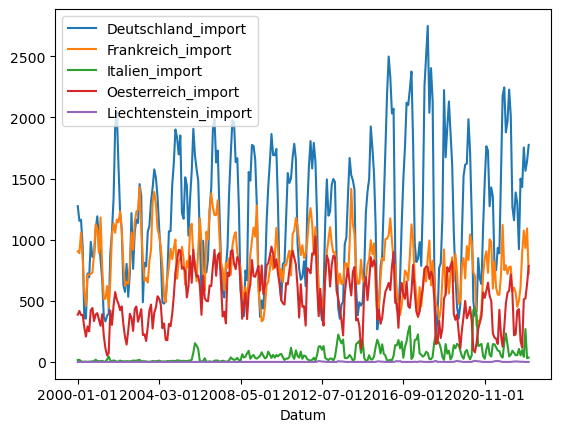

In [63]:
df_import_export_export = df_import_export.copy()
df_import_export_export.reset_index(inplace=True)
df_import_export_export.to_csv('../Data/df_import_export_edited.csv')
df_import_export[['Deutschland_import','Frankreich_import','Italien_import','Oesterreich_import','Liechtenstein_import']].plot()

In [64]:
# convert to long table and save locally
import_export = pd.read_csv('../Data/df_import_export_edited.csv', sep=',').iloc[:,1:7]
import_export.columns = ['Date','Germany','France','Italy','Austria','Liechtenstein']
import_export_long = pd.melt(import_export, id_vars=['Date'], var_name='country', value_name='import_quantity(MWh)')
import_export_long.to_csv('../Data/import_export_long.csv')
import_export_long

,Date,country,import_quantity(MWh)
0,2000-01-01,Germany,1274
1,2000-02-01,Germany,1154
2,2000-03-01,Germany,1162
3,2000-04-01,Germany,947
4,2000-05-01,Germany,358
...,...,...,...
1385,2022-10-01,Liechtenstein,2
1386,2022-11-01,Liechtenstein,0
1387,2022-12-01,Liechtenstein,0
1388,2023-01-01,Liechtenstein,0
